In [ ]:
import sys, os

# add ../src to the Python path (relative to notebooks/)
sys.path.append(os.path.abspath("../src"))
import numpy as np

# Patch for deprecated NumPy aliases (for libraries not updated to NumPy 2.x)
if not hasattr(np, "float_"):
    np.float_ = np.float64

from ODT_v19082025 import hologram_load, FFT_filtering

In [ ]:
import os, re
import numpy as np
import tifffile as tiff
from skimage.transform import resize
from matplotlib import pyplot as plt
from skimage.transform import iradon
import sys, os
from skimage.restoration import unwrap_phase
import time
import os
import matplotlib.image as mpimg   # this gives you mpimg.imread

  

use to upload holograms 

In [ ]:
import os
import numpy as np
import tifffile as tiff
"""
holo_dir = r"..\data\hologram stack"
save_dir = r"..\data\wrapped_phases"
os.makedirs(save_dir, exist_ok=True)

files = sorted([f for f in os.listdir(holo_dir) if f.endswith(".tif") or f.endswith(".tiff")])

for i, filename in enumerate(files[::50]):  # every 50th hologram
    print("Processing", filename)

    hologram = np.squeeze(hologram_load(filename, holo_dir)[0])

    phase_wrapped, _ = FFT_filtering(
        hologram=hologram,
        pixelsize=np.array([0.000438, 0.000438]),
        wavelength=0.000632,
        center_padding=100,
        sample_filter_size=250,
        low_frequency_filter=25,
        filter_type="Linear",
        smoothing_sigma=2
    )

    # save numerical data as TIFF (float32)
    out_path = os.path.join(save_dir, f"wrapped_phase_{i}.tiff")
    tiff.imwrite(out_path, phase_wrapped.astype("float32"))

print(" Done! Saved wrapped phases as .tiff")

"""



'\nholo_dir = r"..\\data\\hologram stack"\nsave_dir = r"..\\data\\wrapped_phases"\nos.makedirs(save_dir, exist_ok=True)\n\nfiles = sorted([f for f in os.listdir(holo_dir) if f.endswith(".tif") or f.endswith(".tiff")])\n\nfor i, filename in enumerate(files[::50]):  # every 50th hologram\n    print("Processing", filename)\n\n    hologram = np.squeeze(hologram_load(filename, holo_dir)[0])\n\n    phase_wrapped, _ = FFT_filtering(\n        hologram=hologram,\n        pixelsize=np.array([0.000438, 0.000438]),\n        wavelength=0.000632,\n        center_padding=100,\n        sample_filter_size=250,\n        low_frequency_filter=25,\n        filter_type="Linear",\n        smoothing_sigma=2\n    )\n\n    # save numerical data as TIFF (float32)\n    out_path = os.path.join(save_dir, f"wrapped_phase_{i}.tiff")\n    tiff.imwrite(out_path, phase_wrapped.astype("float32"))\n\nprint(" Done! Saved wrapped phases as .tiff")\n\n'

In [ ]:
import os
import tifffile as tiff

wrapped_phase_dir = os.path.join("..", "data", "wrapped_phases")  # if notebook is in notebooks/
filename = "wrapped_phase_0.tiff"
path = os.path.join(wrapped_phase_dir, filename)

wrapped_phase = tiff.imread(path)
print(wrapped_phase.shape, wrapped_phase.dtype)


(3072, 4096) float32


1. Sorting by reliability following a noncontinuous path 

The algorithm sorts pixels by how reliable they are and then solves a path integral

Miguel Arevallilo Herráez, David R. Burton, Michael J. Lalor, and Munther A. Gdeisat, "Fast two-dimensional phase-unwrapping algorithm based on sorting by reliability following a noncontinuous path," Appl. Opt. 41, 7437-7444 (2002)

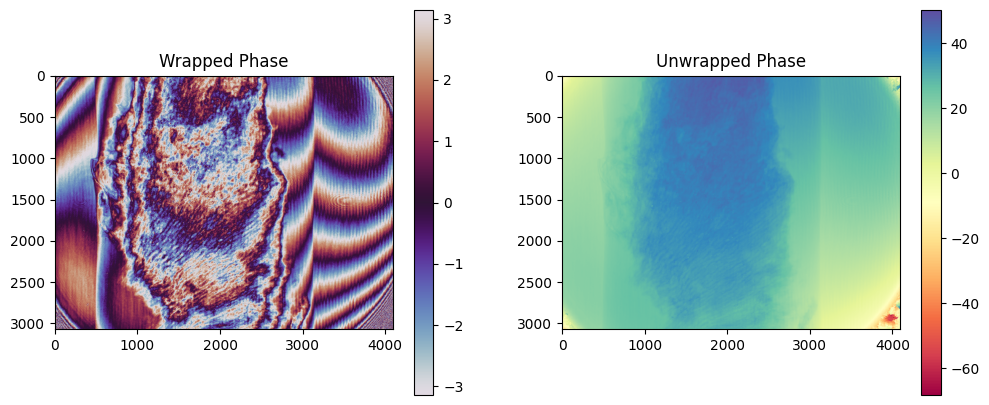

Execution time: 5.4556379318237305 seconds


In [8]:
from skimage.restoration import unwrap_phase

# unwrap
start = time.time()         # record start time
unwrapped = unwrap_phase(wrapped_phase)
end = time.time()           # record end time

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(wrapped_phase, cmap="twilight", vmin=-np.pi, vmax=np.pi)
axes[0].set_title("Wrapped Phase")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(unwrapped, cmap="Spectral")
axes[1].set_title("Unwrapped Phase")
plt.colorbar(im1, ax=axes[1])
plt.show()

print("Execution time:", end - start, "seconds")

Perform 2D phase unwrapping using the weighted least-squares method 
described by Ghiglia and Romero (1994), using DCT-based Poisson solvers. If weighted uses picard iteration

   Ghiglia, D. C., & Romero, L. A. (1994). 
    "Robust two-dimensional weighted and unweighted phase unwrapping that uses 
    fast transforms and iterative methods." JOSA A, 11(1), 107–117.
    https://doi.org/10.1364/JOSAA.11.000107

    https://github.com/Zeekk9/GhiliaUnwap?tab=readme-ov-file

For the weighted option, I used the algorithm from before (sorting by reliability), and added a mask and smoothing of the weights in the borders


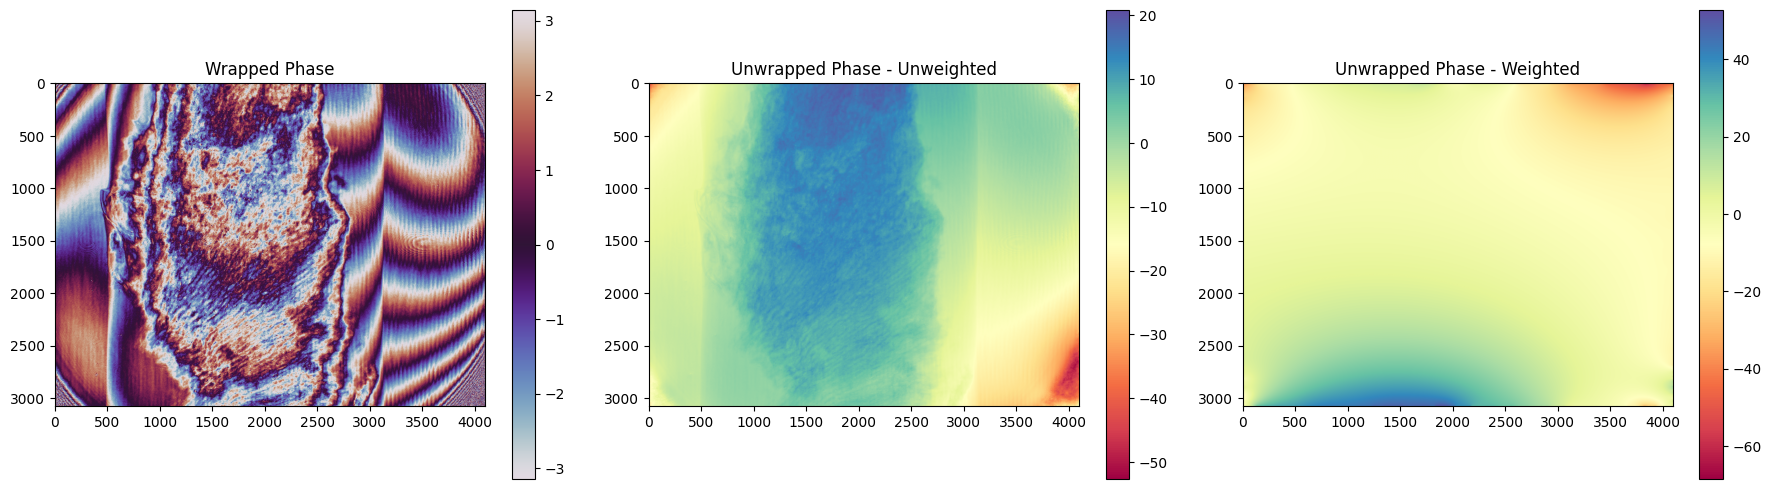

Execution time, unweighted 9.240200996398926 seconds
Execution time, weighted 52.98591160774231 seconds


In [9]:
from Ghilia.Ghilia import unwrap_phase_weighted
from Ghilia.reliability import reliability_weight_map
from scipy.ndimage import gaussian_filter

start1= time.time()
weights = reliability_weight_map(wrapped_phase)
phi_unwrapped_ghilia_weighted = unwrap_phase_weighted(wrapped_phase,weights)
end1= time.time()

start2 = time.time()
phi_unwrapped_ghilia = unwrap_phase_weighted(wrapped_phase)
end2 = time.time()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(wrapped_phase, cmap="twilight", vmin=-np.pi, vmax=np.pi)
axes[0].set_title("Wrapped Phase")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(phi_unwrapped_ghilia, cmap="Spectral")
axes[1].set_title("Unwrapped Phase - Unweighted")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(phi_unwrapped_ghilia_weighted, cmap="Spectral")
axes[2].set_title("Unwrapped Phase - Weighted")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

print("Execution time, unweighted", end2 - start2, "seconds")
print("Execution time, weighted" , end1 - start1, "seconds")


Network Programming based -  Phase differences of neighboring pixels can be estimated with a potential error that is an integer multiple
of 2pi. This suggests the formulation of the phase unwrapping problem as a global minimization problem with integer variables. The phase
unwrapping problem can be equated to the problem of finding the minimum cost flow on a network.

M. Costantini, "A novel phase unwrapping method based on network programming," in IEEE Transactions on Geoscience and Remote Sensing, vol. 36, no. 3, pp. 813-821, May 1998, doi: 10.1109/36.673674.
https://ieeexplore-ieee-org.tudelft.idm.oclc.org/document/673674

PyMaxflow not found, some functions will not be available.


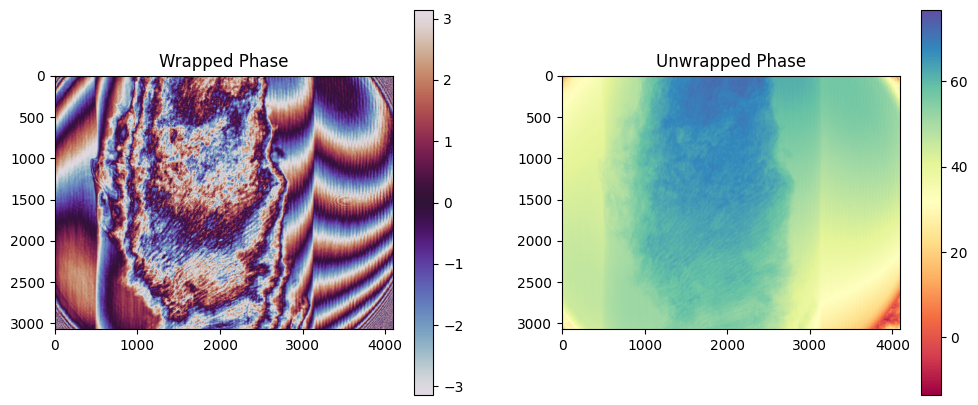

Execution time: 911.1996519565582 seconds


In [10]:
from kamui import unwrap_dimensional

CMAP = 'Spectral'

start = time.time()
unwrapped = unwrap_dimensional(wrapped_phase)
end = time.time()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(wrapped_phase, cmap="twilight", vmin=-np.pi, vmax=np.pi)
axes[0].set_title("Wrapped Phase")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(unwrapped, cmap="Spectral")
axes[1].set_title("Unwrapped Phase")
plt.colorbar(im1, ax=axes[1])
plt.show()


print("Execution time:", end - start, "seconds")

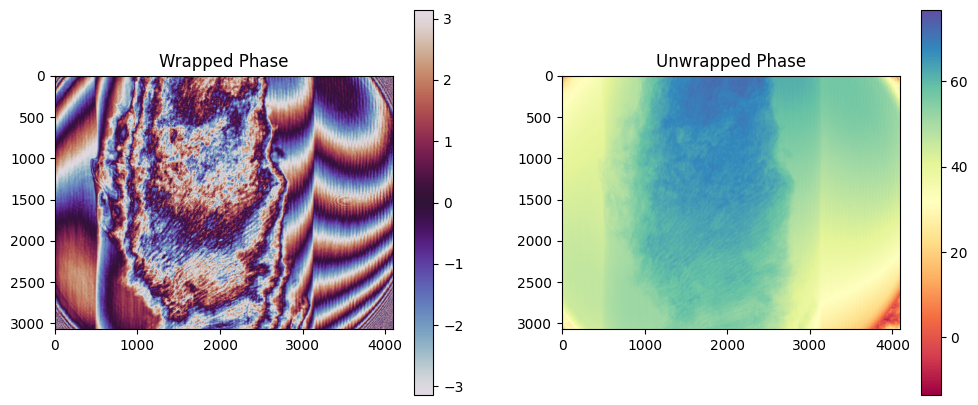

Execution time: 920.6913797855377 seconds


In [14]:
start = time.time()
phi_unwrapped_puma = unwrap_dimensional(
    wrapped_phase,
    merging_method="gc"   # "gc" = graph-cut (PUMA)
)
end = time.time()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(wrapped_phase, cmap="twilight", vmin=-np.pi, vmax=np.pi)
axes[0].set_title("Wrapped Phase")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(unwrapped, cmap="Spectral")
axes[1].set_title("Unwrapped Phase")
plt.colorbar(im1, ax=axes[1])
plt.show()


print("Execution time:", end - start, "seconds")